In [1]:
%load_ext autoreload
%autoreload 2

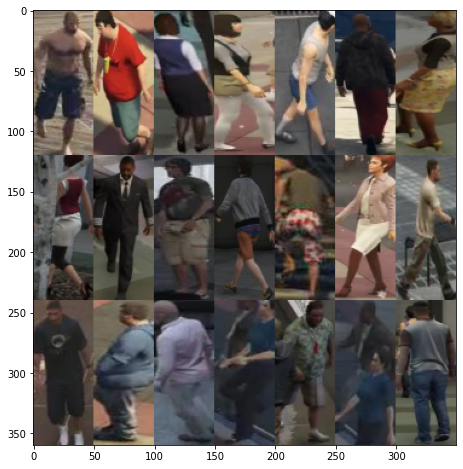

In [33]:
import matplotlib.pyplot as plt
im = plt.imread("./checkpoints/no_wgan_loss_v4/sample/000000.png")
plt.figure(figsize=(8,8))
plt.imshow(im)

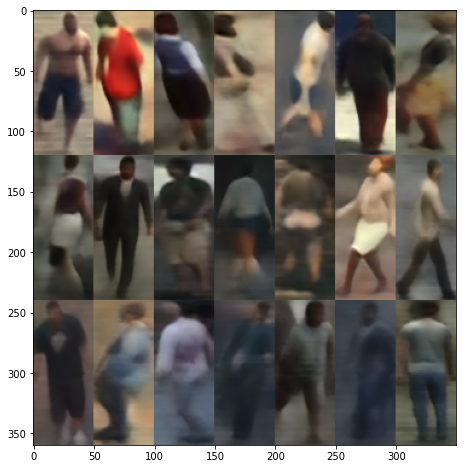

In [41]:
im_num = 91000
import matplotlib.pyplot as plt
im = plt.imread(f"./checkpoints/no_wgan_loss_v4/sample/{str(im_num).zfill(6)}.png")
plt.figure(figsize=(8,8))
plt.imshow(im)

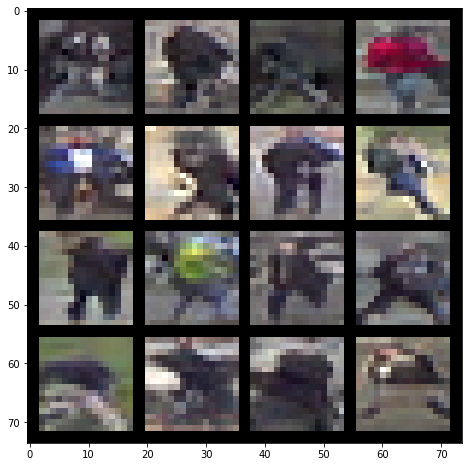

In [21]:
im_num = 40000
import matplotlib.pyplot as plt
im = plt.imread(f"./checkpoints/orig_stylegan/sample/{str(im_num).zfill(6)}.png")
plt.figure(figsize=(8,8))
plt.imshow(im)

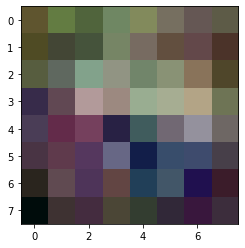

In [8]:
im_num = 2000
import matplotlib.pyplot as plt
from os.path import isfile

for size in (8, 16, 32, 64, 128, 256):
    load_name = f"./checkpoints/orig_stylegan_pretrained/sample/multi_size/{str(im_num).zfill(6)}_{size}.png"
    if isfile(load_name):
        im = plt.imread(load_name)
        plt.imshow(im)
        plt.show()

In [148]:
generator = StyledGenerator(512, classes = dataset.total_ids, use_cls = True)

device = torch.device('cpu')

ckpt = torch.load("./checkpoints/test/050000_128.model", map_location=device)

generator.load_state_dict(ckpt['generator'])



<All keys matched successfully>

In [6]:
transform = transforms.Compose(
        [
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )

dataset = AlignedDatasetLoader('../../datasets/JTA_parsed', '../../datasets/DukeMTMC', transform, resolution = 64)

In [149]:
bs = 16
gen_in1, gen_in2 = torch.randn(2, 16, 512, device='cpu').chunk(2, 0)
gen_in1 = gen_in1.squeeze(0)
gen_in2 = gen_in2.squeeze(0)
loader = sample_data(dataset, 16, 256)
data_loader = iter(loader)
a = next(data_loader)

In [150]:
with torch.no_grad():
    fake_image, _ = generator(a['img_enc'], gen_in2, step=4, alpha=1.)

In [79]:
def show_tensor(im):
    
    im = im.permute(1, 2, 0).numpy()
    print(im.shape)
    plt.imshow(im)
    plt.show()

In [11]:
def sample_data(dataset, batch_size, image_size=4):
    dataset.resolution = image_size
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=1, drop_last=True)

    return loader

In [151]:
img_show = torchvision.utils.make_grid(a['img_enc'], 4, normalize=True, range=(-1, 1),)
show_tensor(img_show)

In [153]:
fake_img_show = torchvision.utils.make_grid(fake_image, 4, normalize=True, range=(-1, 1),)
show_tensor(fake_img_show)

In [9]:
from torchvision import models
import torch.nn as nn
import torch
import os
from dataset import DatasetForClassifier
from dataset import AlignedDatasetLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch
from torchvision import transforms
import torchvision
from model import VGG, PerceptualLoss_v1

In [49]:
model = VGG(8, only_features = True)

In [50]:
model.load("vgg_weights", "VGG_13")

In [29]:
perceptual_loss = PerceptualLoss_v1(resolution = 128, load_path = 'vgg_weights', load_prefix = 'VGG_13')

In [28]:
dit = iter(dataset_loader)
dit2 = iter(dataset_loader2)
a = next(dit)["img"]
b = next(dit2)["img"]

In [10]:
transform = transforms.Compose(
        [
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )

dataset = DatasetForClassifier('../../datasets/JTA_parsed', transform, resolution = 256, classes = 50, val_percent = 0.2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
(256, 256, 3)


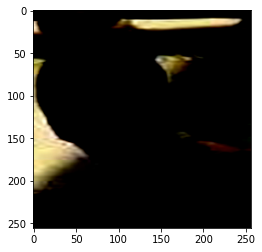

In [80]:
id = 5
print(dataset[id]['img_id'])
show_tensor(dataset[id]['img'])

In [34]:
dataset.train()

In [37]:
dataset.eval()

In [27]:
dataset = DatasetForClassifier("../../datasets/DukeMTMC/", transform, resolution = 128, classes = 700, val_percent = 0.2)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True, num_workers = 4)

In [26]:
dataset2 = DatasetForClassifier("../../datasets/JTA_parsed/", transform, resolution = 128, classes = 700, val_percent = 0.2)
dataset_loader2 = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True, num_workers = 4)

In [40]:
len(dataset)

2032

In [41]:
dataset[-1]

{'img': tensor([[[0.6588, 0.6588, 0.6588,  ..., 0.6941, 0.6941, 0.6941],
          [0.6627, 0.6627, 0.6627,  ..., 0.6902, 0.6902, 0.6902],
          [0.6784, 0.6784, 0.6784,  ..., 0.6863, 0.6863, 0.6863],
          ...,
          [0.8510, 0.8510, 0.8510,  ..., 0.8980, 0.8980, 0.8980],
          [0.8549, 0.8549, 0.8549,  ..., 0.9020, 0.9020, 0.9020],
          [0.8588, 0.8588, 0.8588,  ..., 0.9059, 0.9059, 0.9059]],
 
         [[0.7686, 0.7686, 0.7686,  ..., 0.7804, 0.7804, 0.7804],
          [0.7725, 0.7725, 0.7725,  ..., 0.7765, 0.7765, 0.7765],
          [0.7882, 0.7882, 0.7882,  ..., 0.7725, 0.7725, 0.7725],
          ...,
          [0.8980, 0.8980, 0.8980,  ..., 0.9922, 0.9922, 0.9922],
          [0.9020, 0.9020, 0.9020,  ..., 0.9961, 0.9961, 0.9961],
          [0.9059, 0.9059, 0.9059,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.5412, 0.5412, 0.5412,  ..., 0.6275, 0.6275, 0.6275],
          [0.5451, 0.5451, 0.5451,  ..., 0.6275, 0.6275, 0.6275],
          [0.5608, 0.5608, 0.5608

In [111]:
batch = {}
iterss = {}
with open('default_iter_params', 'r') as f:
    for line in f.readlines():
        resolution = int(line.split()[0])
        bs = line.split()[1]
        iters = line.split()[2]
        batch[int(resolution)] = int(bs)
        iterss[int(resolution)] = int(iters)
print(batch)
print(iterss)

{8: 64, 16: 64, 32: 32, 64: 16, 128: 8, 256: 4}
{8: 10000, 16: 10000, 32: 20000, 64: 40000, 128: 80000, 256: 160000}


In [74]:
from model import OrigStyledGenerator, Discriminator

In [75]:
generator = OrigStyledGenerator(512, n_mlp = 8)
discriminator = Discriminator()
g_running = OrigStyledGenerator(512, n_mlp = 8)

In [77]:
generator.get_mean()

ModuleAttributeError: 'OrigStyledGenerator' object has no attribute 'get_mean'

In [3]:
import torch
from collections import OrderedDict

In [4]:
ckpt = torch.load("./stylegan-256px-new.model")
        
old_ckpt_gen = ckpt['generator']
new_ckpt_gen = OrderedDict()
for k in old_ckpt_gen:
    splited = k.split('.')
    if (splited[0] == 'generator' and (splited[1] == 'progression' or splited[1] == 'to_rgb') and int(splited[2]) <= 6) or splited[0] == 'style':
        new_ckpt_gen.update({k: old_ckpt_gen[k]})

old_ckpt_disc = ckpt['discriminator']
new_ckpt_disc = OrderedDict()
for k in old_ckpt_disc:
#     print(k)
    splited = k.split('.')
    if (splited[0] == 'progression' or splited[0] == 'from_rgb') and int(splited[1]) > 0:
        splited[1] = str(int(splited[1]) - 1)
        if splited[0] == 'from_rgb':
            splited.pop(2)
        new_k = '.'.join(splited)
        new_ckpt_disc.update({new_k: old_ckpt_disc[k]})
    if splited[0] == 'linear':
        new_ckpt_disc.update({k: old_ckpt_disc[k]})

old_ckpt_g = ckpt['g_running']
new_ckpt_g = OrderedDict()
for k in old_ckpt_g:
    splited = k.split('.')
    if (splited[0] == 'generator' and (splited[1] == 'progression' or splited[1] == 'to_rgb') and int(splited[2]) <= 6) or splited[0] == 'style':
        new_ckpt_g.update({k: old_ckpt_g[k]})

generator.load_state_dict(new_ckpt_gen)
discriminator.load_state_dict(new_ckpt_disc)
g_running.load_state_dict(new_ckpt_g)

<All keys matched successfully>

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
from model import OrigStyledGenerator
import torch
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform as sk_transform
from torchvision import transforms
from dataset import BaseDatasetLoader
from model import PerceptualLoss_v1
from tqdm import tqdm
from collections import OrderedDict

device = "cuda"

# StyleGAN loading

In [87]:
def get_stylegan(ckpt_name = None):
    generator = OrigStyledGenerator(512, n_mlp = 8).to(device)
    if ckpt_name is None:
        ckpt = torch.load("./stylegan-256px-new.model")

        old_ckpt_g = ckpt['g_running']
        new_ckpt_g = OrderedDict()
        for k in old_ckpt_g:
            splited = k.split('.')
            if (splited[0] == 'generator' and (splited[1] == 'progression' or splited[1] == 'to_rgb') and int(splited[2]) <= 6) or splited[0] == 'style':
                new_ckpt_g.update({k: old_ckpt_g[k]})

        generator.load_state_dict(new_ckpt_g)
    else:
        ckpt = torch.load(ckpt_name, map_location = device)
        step = ckpt['step']
        generator.load_state_dict(ckpt['g_running'])
    generator.eval()
    return generator

In [ ]:
generator = get_stylegan()
# generator  = get_stylegan("./checkpoints/orig_stylegan_pretrained/320000_256.model")

# Visualizers

In [240]:
def show_batch(generator, mean_style = None, style_weight = 0.7, target_shape = (120, 50)):
    num_cols = 10
    num_rows = 2
    result_image = np.zeros((num_rows * target_shape[0], num_cols * target_shape[1], 3), dtype = np.float32)
    for nr in range(num_rows):
        for nc in range(num_cols):
            im = generator(
                torch.randn(1, 512).to(device),
                step = step,
                alpha=1,
                style_weight=style_weight,
                mean_style = mean_style
            )
            n_im = unnorm_image(n_im)
            n_im = sk_transform.resize(n_im, target_shape)
            result_image[target_shape[0] * nr:target_shape[0] * (nr + 1), target_shape[1] * nc:target_shape[1] * (nc + 1), :] = n_im[:, :, :]
    plt.figure(figsize=(16, 10))
    plt.title("Samples from " + "Styled Generator")
    plt.axis('off')
    plt.imshow(result_image)
    
def unnorm_image(im):
    if len(im.size()) == 4:
        im = im[0]
    n_im = torch.clamp(im, -1, 1).detach().cpu().numpy()
    n_im = (np.transpose(n_im, (1, 2, 0)) + 1) / 2.0 * 255.0
    n_im = n_im.astype(np.uint8)
    return n_im
    
def show_image(im, target_shape = (120, 50)):
    if len(im.size()) == 4 or im.size(0) == 3:
        im = unnorm_image(im)
    im = sk_transform.resize(im, target_shape)
    
    plt.imshow(im)
    plt.show()
    
def show_batch_from_list(image_list, target_shape = (120, 50), num_cols = 16):
    num_cols = num_cols
    num_rows = len(image_list) // num_cols + 1 if len(image_list) % num_cols != 0 else len(image_list) // num_cols
    result_image = np.zeros((num_rows * target_shape[0], num_cols * target_shape[1], 3), dtype = np.float32)
    nr = 0
    nc = 0
    for n_im in image_list:
        n_im = unnorm_image(n_im)
        n_im = sk_transform.resize(n_im, target_shape)
        result_image[target_shape[0] * nr:target_shape[0] * (nr + 1), target_shape[1] * nc:target_shape[1] * (nc + 1), :] = n_im[:, :, :]
        nc += 1
        if nc == num_cols:
            nc = 0
            nr += 1
    plt.figure(figsize=(16, 10))
    plt.title("Samples from " + "Styled Generator")
    plt.axis('off')
    plt.imshow(result_image)
    
def get_dataset(dataset_path):
    transform = transforms.Compose(
        [
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )
    
    return BaseDatasetLoader(dataset_path, transform, resolution = 256)

# Code operations

In [197]:
def get_style(generator):
    return generator.mean_style(torch.randn(1, 512).to(device))

def get_random_style():
    return torch.rand((14, 512))

def get_mean_style(generator):
    mean_style = None
    for i in range(10):
        style = generator.mean_style(torch.randn(1024, 512).to(device))
        if mean_style is None:
            mean_style = style
        else:
            mean_style += style
    mean_style /= 10
    return mean_style

def get_expanded_style_code(style_code):
    style_code = style_code.unsqueeze(1)
    style_code = torch.cat([style_code for i in range(14)], 1)
    return style_code
    
def get_image(generator, style_code, style_weight = 1., mean_style = None): # (bs, 512) or (bs, 14, 512)
    if len(style_code.size()) == 2:
        style_code = get_expanded_style_code(style_code)
        
    with torch.no_grad():
        im = generator.forward2(
            style_code,
            step = step,
            alpha=1,
            style_weight = style_weight,
            mean_style = mean_style
        )
    return im

# images_list TODO
def get_image_code(generator, image, init = "random", num_iters = 3000, w_init = None, show_every = None):
    if w_init is None and init == "random":
        w = get_random_style().unsqueeze(0)
    if w_init is None and init == "mean": 
        w = get_expanded_style_code(get_mean_style(generator))
        
    image = image.to(device)
        
    w = torch.autograd.Variable(w, requires_grad = True).to(device)
    w_p = torch.nn.Parameter(w).to(device)
    optimizer = torch.optim.Adam([w_p], lr = 0.001)
    
    l2 = torch.nn.MSELoss()
    perceptual_loss = PerceptualLoss_v1(resolution = 256).to(device)
    
    if len(image.size()) != 4:
        image = image.unsqueeze(0)
    
    for i in tqdm(range(1, num_iters + 1)):
        optimizer.zero_grad()
        gen_im = generator.forward2(w_p, step = step, alpha=1,)
        loss = l2(image, gen_im) + perceptual_loss(image, gen_im)
        loss.backward()
        optimizer.step()
        
        if show_every is not None and i % show_every == 0:
            show_image(get_image(generator, w))
        
    return w

In [166]:
jta_parsed = get_dataset('../../datasets/JTA_parsed/')
duke = get_dataset('../../datasets/DukeMTMC/')

In [235]:
generator = get_stylegan()

In [237]:
generator  = get_stylegan("./checkpoints/orig_stylegan_pretrained/320000_256.model")

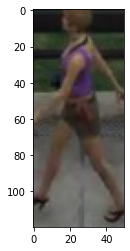

 25%|██▍       | 999/4000 [00:48<02:25, 20.62it/s]

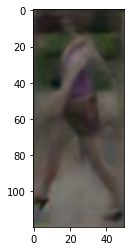

 50%|████▉     | 1998/4000 [01:36<01:37, 20.48it/s]

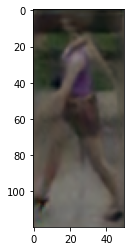

 75%|███████▍  | 2997/4000 [02:25<00:49, 20.46it/s]

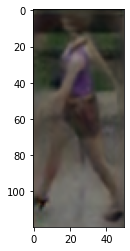

100%|█████████▉| 3999/4000 [03:15<00:00, 20.24it/s]

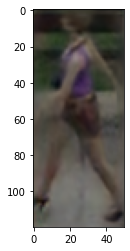

100%|██████████| 4000/4000 [03:15<00:00, 20.48it/s]


In [238]:
img_from = jta_parsed[104]['img']
show_image(img_from)
w_from = get_image_code(generator, img_from, num_iters = 4000, init = "random", show_every = 1000)

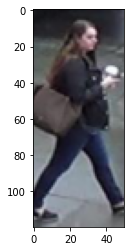

 25%|██▍       | 999/4000 [00:49<02:28, 20.23it/s]

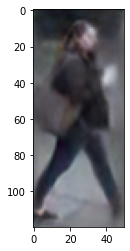

 50%|████▉     | 1997/4000 [01:38<01:39, 20.22it/s]

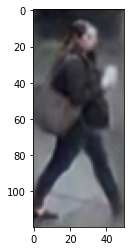

 75%|███████▍  | 2999/4000 [02:28<00:49, 20.19it/s]

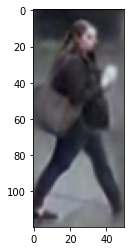

100%|█████████▉| 3998/4000 [03:18<00:00, 20.21it/s]

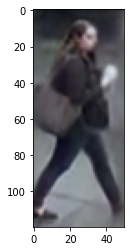

100%|██████████| 4000/4000 [03:18<00:00, 20.16it/s]


In [217]:
img_to = duke[1070]['img']
show_image(img_to)
w_to = get_image_code(generator, img_to, num_iters = 4000, init = "random", show_every = 1000)

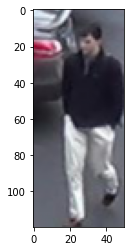

 25%|██▍       | 999/4000 [00:49<02:27, 20.40it/s]

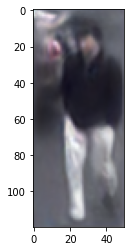

 50%|████▉     | 1998/4000 [01:38<01:38, 20.32it/s]

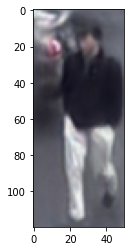

 75%|███████▍  | 2997/4000 [02:27<00:49, 20.19it/s]

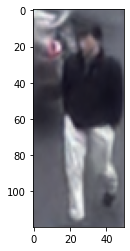

100%|█████████▉| 3999/4000 [03:17<00:00, 20.20it/s]

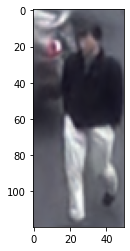

100%|██████████| 4000/4000 [03:17<00:00, 20.26it/s]


In [239]:
img_to_2 = duke[200]['img']
show_image(img_to_2)
w_to_2 = get_image_code(generator, img_to_2, num_iters = 4000, init = "random", show_every = 1000)

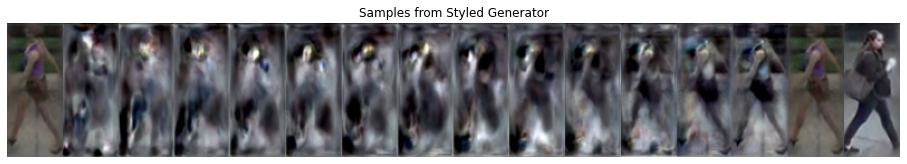

In [219]:
img_list = []
# img_list.append(get_image(generator, w_from))
st = get_expanded_style_code(get_mean_style(generator))
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    w_s = torch.cat([w_from[:,0:i,:], w_to[:,i:14:,:]], 1)
    img_list.append(get_image(generator, w_s))

# img_list.append(get_image(generator, w_to))
    
show_batch_from_list(img_list)

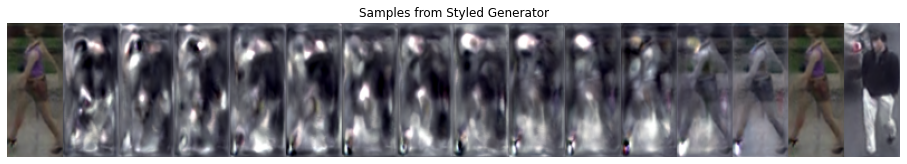

In [241]:
img_list = []
img_list.append(get_image(generator, w_from))
st = get_expanded_style_code(get_mean_style(generator))
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    w_s = torch.cat([w_from[:,0:i,:], w_to_2[:,i:14:,:]], 1)
    img_list.append(get_image(generator, w_s))

img_list.append(get_image(generator, w_to_2))
    
show_batch_from_list(img_list)

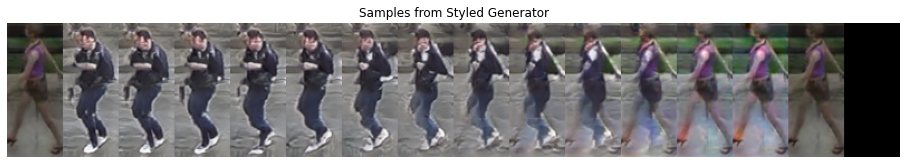

In [228]:
img_list = []
# img_list.append(get_image(generator, w_from))
st = get_expanded_style_code(get_mean_style(generator))
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    w_s = torch.cat([w_from[:,0:i,:], st[:,i:14:,:]], 1)
    img_list.append(get_image(generator, w_s))

# img_list.append(get_image(generator, w_to))
    
show_batch_from_list(img_list)